### Objective: Build a Neural Network that predicts the next word in a sentence given the previous 3 

- Applying weight sharing
- Multi-layer perceptrons

--> Solve it twice: 

- from scratch using numpy (Implementing forward propagation and backpropagation manually)    
- using PyTorch

### I. DATA EXPLORATION

In [2]:
import pandas as pd
import numpy as np

In [3]:
## Reading the sentences
file_path = "raw_sentences.txt"

sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

In [4]:
## Extracting info
vocab = set([w for s in sentences for w in s])
print("There are {} sentences in total".format(len(sentences)))
print("These sentences are composed of {} distinct words".format(len(vocab)))

There are 97162 sentences in total
These sentences are composed of 250 distinct words


#### Splitting data into TRAINING, VALIDATION and TEST sets

- 10% sentences for Validation  ----  9716 sentences
- 10% sentences for Testing     ----  9716 sentences
- 80% sentences for Training    ----  77730 sentences

In [5]:
## Shuffling Data Set
import random 
sentences_shuffled = sentences.copy()
random.shuffle(sentences_shuffled)

In [6]:
## Splitting data
ind = round(len(sentences) * 0.1)
test, valid, train = sentences_shuffled[:ind], sentences_shuffled[ind:2*ind], sentences_shuffled[2*ind:]

In [7]:
len(test) + len(valid) + len(train) == len(sentences)

True

#### Understanding the data

In [8]:
## Printing first 10 sentences in training dara
for i, s in enumerate(train):
    if i == 10: break
    print(s)

['and', 'so', 'it', 'was', 'for', 'all', '.']
['that', 'he', 'is', ',', 'and', 'a', 'good', 'one', 'too', '.']
['all', 'that', 'is', 'over', 'now', '.']
['now', 'she', 'has', 'two', '.']
['he', 'is', 'never', 'here', '.']
['we', 'are', 'one', 'over', 'now', '.']
['but', 'they', 'are', 'all', 'around', '.']
['but', 'that', "'s", 'how', 'life', 'is', '.']
['i', 'just', 'want', 'to', 'work', 'and', 'for', 'our', 'team', 'to', 'work', '.']
['today', 'is', 'over', ',', 'she', 'said', '.']


Note that: 

- punctuation is represented as a single independent string, just like the other words from the data
- words with apostrophes are put together in the same string and count as a single word.

#### Visualizing distributional properties of the data (training set)

In [9]:
## Computing average length of a sentence in training set
tot_wds = 0
for s in train:
    tot_wds += len(s)

avg_wds = tot_wds / len(train)
print("The average length of a sentence (i.e. nb of words) is ", avg_wds)

The average length of a sentence (i.e. nb of words) is  7.795407178695484


In [10]:
## Displaying total of words in training set
print("Total number of words in the training set is: ", tot_wds)

Total number of words in the training set is:  605937


In [11]:
## Computing number of unique words in training set
vocab_train = set([w for s in train for w in s])
print("There are {} distinct words in the training set".format(len(vocab_train)))

There are 250 distinct words in the training set


Note that all 250 words for all the data are present in the training set

In [12]:
## Computing 10 most common words in training set
from collections import Counter

counter = Counter()
for s in train:
    counter.update(s)

most_common = counter.most_common(10)
print("The top 10 most common words in the training set are: ", "\n")

for x in most_common:
    print("Word: {} , number of occurences: {}".format(x[0], x[1]))

The top 10 most common words in the training set are:  

Word: . , number of occurences: 64731
Word: it , number of occurences: 23425
Word: , , number of occurences: 19617
Word: i , number of occurences: 17817
Word: do , number of occurences: 16256
Word: to , number of occurences: 15663
Word: nt , number of occurences: 13135
Word: ? , number of occurences: 13018
Word: that , number of occurences: 12707
Word: the , number of occurences: 12700


In [13]:
## Computing frequency of top 10 most common words
freqs = []
for x in most_common:
    f = (x[1] / tot_wds) * 100
    freqs.append((x[0], f))

print("Frequency for the top 10 most common words is: ", "\n")

for x in freqs:
    print("Word: {}, frequency: {}".format(x[0], x[1]))

Frequency for the top 10 most common words is:  

Word: ., frequency: 10.682793755786493
Word: it, frequency: 3.865913453048749
Word: ,, frequency: 3.237465281044069
Word: i, frequency: 2.940404695537655
Word: do, frequency: 2.682787154440148
Word: to, frequency: 2.584922194881646
Word: nt, frequency: 2.1677171059037494
Word: ?, frequency: 2.148408167845832
Word: that, frequency: 2.0970827000166685
Word: the, frequency: 2.0959274644063655


Note that: 
- if we were to build a baseline model that simply returns the most common word as the prediction, the accuracy of that model would be the frequency of the most common word.

#### One hot encoding the data (i.e. assigning each word to a unique integer index)

In [14]:
## Defining useful variables for one hot encoding

vocab = sorted(list(set([w for s in train for w in s]))) #A list of all the words in the data set. We will assign a unique dentifier for each of these words.
vocab_itos = dict(enumerate(vocab)) # A mapping of index => word (string)
vocab_stoi = {word: index for index, word in vocab_itos.items()} # A mapping of word => its index

In [15]:
## Defining helpers for one hot encoding

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    
    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]

    """
    sents_ind = []
    for s in sents:
        inds = [vocab_stoi[w] for w in s]
        sents_ind.append(inds)
    return sents_ind

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    
    """

    grams = []
    for s in seqs:
        ind1, ind2 = 0, 4
        while ind2 <= len(s):
            grams.append(s[ind1:ind2])
            ind1 += 1
            ind2 += 1 
    return grams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates a
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.

    """
    inds = convert_words_to_indices(sents)
    four_grams = generate_4grams(inds)
    return np.array(four_grams)

In [16]:
## Processing the data
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

### II. MODEL DESCRIPTION AND BACKGOUND MATH

Suppose we were to use a 2-layer multilayer perceptron to solve this prediction problem. Our model will look like this:

<p align="center">
    <img src="img_models/model1.png" />
</p>

\begin{align*}
\bf{x} &= \text{concatenation of the one-hot vector for words 1, 2 and 3} \\
\bf{m} &= \bf{W^{(1)}} \bf{x} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) =  \frac{1}{2} \cdot {||y−t||}^2\\
\end{align*}


Let: 
- K be the size of the hidden layer
- T be the total number of unique words

Then we have the following shapes for the matrices and vectors of the model:
- $x \rightarrow (3T, 1)$

- $y \rightarrow (T, 1)$

- $t \rightarrow (T, 1)$

- ${W^{(1)}} \rightarrow (K, 3T)$

- ${W^{(2)}} \rightarrow (T, K)$

- ${b^{(1)}} \rightarrow (K, 1)$

- ${b^{(2)}} \rightarrow (T, 1)$


We will use gradient descent to optimize the quantities 
$W^{(1)}$, $W^{(2)}$, $b^{(1)}$ and $b^{(2)}$. In other words,
we will need to compute 
$\frac{\partial L}{\partial W^{(1)}}$,
$\frac{\partial L}{\partial W^{(2)}}$,
$\frac{\partial L}{\partial b^{(1)}}$, and
$\frac{\partial L}{\partial b^{(2)}}$.

To do so, we will need to use the backpropagation algorithm.
Thus, it is helpful to start by drawing a computation graph.

Here is the computation graph for our model, with matrix addition, multiplication, and `softmax` and `ReLU` activations as primitive operations.

<p align="center">
    <img src="img_models/CG-1.png" />
</p>

Now, we derive the gradient descent update rule for $W^{(1)}$, $W^{(2)}$, $b^{(1)}$ and $b^{(2)}$. We will begin by deriving the update rules for $W^{(2)}_{tk}, b^{(2)}_t, W^{(1)}_{ks}$, and $b^{(1)}_k$. 
Then, we will vectorize our answers.

#### Gradient descent update rule for $W^{(2)}_{tk}, b^{(2)}_t$


First we need:

- $\frac{\partial L}{\partial y_t} = \overline{y_t} =\frac{\partial}{\partial y_t} [-t_t \cdot log(y_t) - (1 - t_t) \cdot log(1 - y_t)] = \frac{y_t - t_t}{y_t \cdot (1 - y_t)}$

- $\frac{\partial L}{\partial z_t} = \overline{z_t} = \overline{y_t} \cdot \frac{\partial y_t}{\partial z_t} = \overline{y_t} \cdot \frac{\partial}{\partial z_t}[softmax(z_t)] =  \overline{y_t}  \cdot \frac{\partial}{\partial z_t}[\frac{1}{1 + e^{-z_t}}] = \overline{y_t} \cdot \frac{e^{-z_t}}{(1 + e^{-z_t})^2} = \overline{y_t} \cdot y_t \cdot (1-y_t) =  \frac{y_t - t_t}{y_t \cdot (1 - y_t)} \cdot y_t \cdot (1-y_t) = y_t - t_t$

**Vecotrized: $\overline{z} = y - t$**

Now we can determine:

$\frac{\partial L}{\partial  W^{(2)}_{tk}} = \overline{ W^{(2)}_{tk}} = \overline{z_t} \cdot \frac{\partial z_t}{\partial  W^{(2)}_{tk}} = \overline{z_t} \cdot \frac{\partial}{\partial  W^{(2)}_{tk}}[\sum_{k}^{} W^{(2)}_{tk} \cdot h_k + b_t^{(2)}] = \overline{z_t} \cdot h_k$

**Vectorized: $\overline{ W^{(2)}} = \overline{z} \cdot h^T$**

$\frac{\partial L}{\partial  b^{(2)}_t} =  \overline{b^{(2)}_t} = \overline{z_t} \cdot \frac{\partial z_t}{\partial  b^{(2)}_t} = \overline{z_t} \cdot \frac{\partial}{\partial  b^{(2)}_t}[\sum_{k}^{} W^{(2)}_{tk} \cdot h_k + b_t^{(2)}] = \overline{z_t} \cdot 1 = \overline{z_t}$

**Vectorized: $\overline{b^{(2)}} = \overline{z}$**

#### Gradient descent update rule for $W^{(1)}_{ks}$, $b^{(1)}_k$

First we need:

- $\frac{\partial L}{\partial h_k} = \overline{h_k} = \sum_{t}^{} \overline{z_t} \cdot \frac{\partial z_t}{\partial h_k} =  \sum_{t}^{} \overline{z_t} \cdot W^{(2)}_{tk}$ 

- $\frac{\partial L}{\partial m_k} = \overline{m_k} = \overline{h_k} \cdot \frac{\partial h_k}{\partial m_k} = \overline{h_k} \cdot \frac{\partial}{\partial m_k}[ReLU(m_k)]$

**Vectorized: $\overline{h} = W^{(2)^{T}} \cdot \overline{z}$ and $\overline{m} = \overline{h} \odot \frac{\partial}{\partial m_k}[ReLU(m)]$**

Now we can determine:

$\frac{\partial L}{\partial W^{(1)}_{ks}} = \overline{W^{(1)}_{ks}} = \overline{m_k} \cdot \frac{\partial m_k}{\partial W^{(1)}_{ks}} = \overline{m_k} \cdot \frac{\partial}{\partial W^{(1)}_{ks}}[\sum_{s}^{} W^{(1)}_{ks} \cdot x_s + b_k^{(1)}] = \overline{m_k} \cdot x_s$

**Vectorized: $\overline{W^{(1)}} = \overline{m} \cdot x^T$**

$\frac{\partial L}{\partial  b^{(1)}_k} =  \overline{b^{(1)}_k} = \overline{m_k} \cdot \frac{\partial m_k}{\partial  b^{(1)}_k} = \overline{m_k} \cdot 1 = \overline{m_k}$

**Vectorized: $\overline{b^{(1)}} = \overline{m}$**

#### Change of architectue

From this point onward, we will modify our architecture to introduce **weight sharing**.
In particular, the input $\bf{x}$ consists of three one-hot vectors concatenated
together. We can think of $\bf{h}$ as a representation of those three words
(all together). However, $\bf{W^{(1)}}$ needs to learn about the first word
separately from the second and third word, when some of the information could
be shared. Consider the following architecture:

<p align="center">
    <img src="img_models/model2.png" />
</p>

Here, we add an extra *embedding* layer to the neural network, where we compute
the representation of **each** word before concatenating them together! We use
the same weight $\bf{W}^{(word)}$ for each of the three words:

\begin{align*}
\bf{x_a} &= \textrm{the one-hot vector for word 1} \\
\bf{x_b} &= \textrm{the one-hot vector for word 2} \\
\bf{x_c} &= \textrm{the one-hot vector for word 3} \\
\bf{v_a} &= \bf{W}^{(word)} \bf{x_a} \\
\bf{v_b} &= \bf{W}^{(word)} \bf{x_b} \\
\bf{v_c} &= \bf{W}^{(word)} \bf{x_c} \\
\bf{v} &= \textrm{concatenation of } \bf{v_a}, \bf{v_b}, \bf{v_c} \\
\bf{m} &= \bf{W^{(1)}} \bf{v} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) \\
\end{align*}

We will now need to derive the math required to train this model by gradient descent. (Note that we can still use our previous results!!)

First, lets write out the shape of each of the above quantities: (Note that there are no biases in the embedding layer)

Let: 
- K be the size of the hidden layer
- T be the total number of unique words
- Q be the size of the word embedding

Shapes:

- $x_a \rightarrow (T, 1)$, &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $x_b \rightarrow (T, 1)$, &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $x_c \rightarrow (T, 1)$

- $v_a \rightarrow (Q, 1)$, &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $v_b \rightarrow (Q, 1)$, &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $v_c \rightarrow (Q, 1)$

- $v \rightarrow (3Q, 1)$

- $m \rightarrow (K, 1)$

- $h \rightarrow (K, 1)$

- $z \rightarrow (T, 1)$

- $y \rightarrow (T, 1)$

- $t \rightarrow (T, 1)$

- ${W^{(word)}} \rightarrow (Q, T)$

- ${W^{(1)}} \rightarrow (K, 3Q)$

- ${W^{(2)}} \rightarrow (T, K)$

- ${b^{(1)}} \rightarrow (K, 1)$

- ${b^{(2)}} \rightarrow (T, 1)$

We will use gradient descent to optimize the quantities 
$W^{(word)}$, $W^{(1)}$, $W^{(2)}$, $b^{(1)}$ and $b^{(2)}$. In other words,
we will need to compute 
$\frac{\partial L}{\partial W^{(word)}}$,
$\frac{\partial L}{\partial W^{(1)}}$,
$\frac{\partial L}{\partial W^{(2)}}$,
$\frac{\partial L}{\partial b^{(1)}}$, and
$\frac{\partial L}{\partial b^{(2)}}$.

Same as before, we will sart by drawing a computation graph:

<p align="center">
    <img src="img_models/CG-2.png" />
</p>

Note that the gradient descent update rule for the quantities ${\bf W}^{(2)}$,
${\bf b}^{(2)}$, ${\bf W}^{(1)}$, and
${\bf b}^{(1)}$ are identical to the results previously computated for the old model since the computation graph from v onwards is also identical to the one for the old model, thus, the quantities affect each other in the same way.  

Therefore, we now only need to compute the gradient descent update rule for ${\bf W}^{(word)}$

First we need:

- $\frac{\partial L}{\partial v_{s}} = \overline{v_s} = \sum_{k}^{} \overline{m_k} \cdot \frac{\partial m_k}{\partial v_{s}} = \sum_{k}^{} \overline{m_k} \cdot  W^{(1)}_{ks}$, **vectorized: $\overline{v} = W^{(1)^T} \overline{m}$**

-  $\frac{\partial L}{\partial v_{a}} = \overline{v_a} = \overline{v}[:Q]$ (Slicing)

-  $\frac{\partial L}{\partial v_{b}} = \overline{v_b} = \overline{v}[Q:2Q]$ (Slicing)

-  $\frac{\partial L}{\partial v_{c}} = \overline{v_c} = \overline{v}[2Q:]$ (Slicing)

Now we can determine:

$\frac{\partial L}{\partial W^{(word)}} = \overline{W^{(word)}} = \overline{v_a} \cdot x_a^T + \overline{v_b} \cdot x_b^T + \overline{v_c} \cdot x_c^T$


#### Summarizing results

In summary, all of our results vectorizied consist of:

- $\overline{z} = y - t$

- $\overline{ W^{(2)}} = \overline{z} \cdot h^T$

- $\overline{b^{(2)}} = \overline{z}$

- $\overline{h} = W^{(2)^{T}} \cdot \overline{z}$

- $\overline{m} = \overline{h} \odot \frac{\partial}{\partial m_k}[ReLU(m)]$

- $\overline{W^{(1)}} = \overline{m} \cdot x^T$

- $\overline{b^{(1)}} = \overline{m}$

- $\overline{v} = W^{(1)^T} \overline{m}$

- $\overline{v_a} = \overline{v}[:Q]$

- $\overline{v_b} = \overline{v}[Q:2Q]$

- $\overline{v_c} = \overline{v}[2Q:]$

- $\overline{W^{(word)}} = \overline{v_a} \cdot x_a^T + \overline{v_b} \cdot x_b^T + \overline{v_c} \cdot x_c^T$

### III. BUILDING THE NEURAL NETWORK WITH NUMPY

Implementing Helpers

In [17]:
### Helper functions

def make_onehot(indices, total=250):
    """
    Convert indicies into one-hot vectors by
        1. Creating an identity matrix of shape [total, total]
        2. Indexing the appropriate columns of that identity matrix
    """
    I = np.eye(total)
    return I[indices]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.

    """
    x = x.T
    exps = np.exp(x - x.max(axis=0)) 
    probs = exps / np.sum(exps, axis=0)
    return probs.T

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xs, ts) where:
     - `xs` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `ts` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xs = data[range_min:range_max, :3]
    xs = make_onehot(xs)
    ts = data[range_min:range_max, 3]
    if onehot:
        ts = make_onehot(ts).reshape(-1, 250)
    return xs, ts

def estimate_accuracy(model, data, batch_size=5000, max_N = 100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """

    correct = 0
    N=0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        z = model(xs)
        pred = np.argmax(z, axis=1)
        correct += np.sum(ts == pred)
        N += ts.shape[0]

        if N > max_N:
            break
        
    return correct / N


We will represent the model as a Python class, and will set up the class methods and APIs in a way similar to PyTorch.

1. in the `__init__` method, initialize the weights and biases to have the correct shapes.
2. Implement the `forward` method to compute the predictions given a **batch** of inputs. This function will also store the intermediate values obtained in the computation; as we will need these values for gradient descent.
3. Implement the `backward` method to compute the gradients of the loss with respect to the weights and biases.
4. Implement the `update` method that uses the stored gradients to update the weights and biases.

In [18]:
class NumpyWordEmbModel(object):
    def __init__(self, vocab_size=250, emb_size=100, num_hidden=100):
        """
        Initialize the weights and biases to zero. Update this method
        so that weights and baises have the correct shape.
        """
        T, Q, K = vocab_size, emb_size, num_hidden
        self.vocab_size, self.emb_size, self.num_hidden  = T, Q, K
       
        self.emb_weights = np.zeros([Q, T])
        self.weights_1 = np.zeros([K, 3*Q])
        self.bias_1 = np.zeros([K])
        self.weights_2 = np.zeros([T, K])
        self.bias_2 = np.zeros([T])

        self.cleanup()

    def initialize_params(self):
        """
        Randomly initialize the weights and biases of this two-layer MLP.
        The randomization is necessary so that each weight is updated to
        a different value.
        """
        self.emb_weights = np.random.normal(0, 2/self.emb_size, self.emb_weights.shape)
        self.weights_1 = np.random.normal(0, 2/self.emb_size, self.weights_1.shape)
        self.bias_1 = np.random.normal(0, 2/self.emb_size, self.bias_1.shape)
        self.weights_2 = np.random.normal(0, 2/self.num_hidden, self.weights_2.shape)
        self.bias_2 = np.random.normal(0, 2/self.num_hidden, self.bias_2.shape)
    
    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.

        Note that for vectorization, `inputs` will be a rank-3 numpy array
        with shape [N, 3, vocab_size], where N is the batch size.
        The returned value will contain the predictions for the N
        data points in the batch, so the return value shape should be
        [N, something].

        For numerical stability reasons, we will return the **logit z**
        instead of the **probability y**. The loss function assumes that 
        we return the logits from this function.

        Testing: 
        xs, ts = get_batch(train4grams, 0, 8, onehot=True)
        m = NumpyWordEmbModel()
        m.forward(xs)
        """
         
        self.N = inputs.shape[0]
        self.xa = inputs[:, 0] # (N, T)
        self.xb = inputs[:, 1] # (N, T)
        self.xc = inputs[:, 2] # (N, T)

        self.va = np.matmul(self.emb_weights, self.xa.T) # (Q, N)
        self.vb = np.matmul(self.emb_weights, self.xb.T) # (Q, N)
        self.vc = np.matmul(self.emb_weights, self.xc.T) # (Q, N)
        self.v = np.vstack((self.va, self.vb, self.vc))  # (3Q, N)

        self.m = (np.matmul(self.weights_1, self.v)).T + self.bias_1 # Transpose to broadcast the bias (N, K)
        self.h = np.maximum(self.m.T, 0) # (K, N)
        self.z = (np.matmul(self.weights_2, self.h)).T + self.bias_2 # Transpose to broadcast the bias (N, T)

        self.y = softmax(self.z)

        return self.z
    
    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a numpy array with shape [N, vocab_size].

        Assume that the forward() method has already been called, so
        we can access values like self.N, self.y, etc..

        This function needs to be called before calling the update() method.
        """
        z_bar = (self.y - ts) / self.N # (N, T)
        self.w2_bar = np.matmul(z_bar.T, self.h.T) # (T, K)
        self.b2_bar = z_bar.T

        h_bar = np.matmul(self.weights_2.T, z_bar.T) # (K, N)
        m_deriv = (self.m > 0) * 1
        m_bar = h_bar * m_deriv # (K, N)
        self.w1_bar = np.matmul(m_bar, self.v.T) # (K, 3Q)
        self.b1_bar = m_bar # (K, N)

        v_bar = np.matmul(self.weights_1.T, m_bar) # (3Q, N)
        va_bar = v_bar[: self.emb_size] # (Q, N)
        vb_bar = v_bar[self.emb_size: 2*self.emb_size] # (Q, N)
        vc_bar = v_bar[2*self.emb_size: ] # (Q, N)
        self.emb_bar = np.matmul(va_bar, self.xa) + np.matmul(vb_bar, self.xb) + np.matmul(vc_bar, self.xc) # (Q, T)

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        Let `alpha` be the learning rate.

        Assume that the forward() and backward() methods have already
        been called, thus, we can access values like self.w1_bar.
        """
        self.weights_1 -= alpha * self.w1_bar
        self.bias_1 -= np.sum(alpha * self.b1_bar, axis=1)
        
        self.weights_2 -= alpha * self.w2_bar
        self.bias_2 -= np.sum(alpha * self.b2_bar, axis=1)

        self.emb_weights -= alpha * self.emb_bar

    def __call__(self, inputs):
        """
        This function is here so that if you call the object like a function,
        the `backward` method will get called. For example, if we have
            m = NumpyWordEmbModel()
        Calling `m(foo)` is equivalent to calling `m.forward(foo)`.

        """
        return self.forward(inputs)
    
    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
       
        You do not need to change this method.
        """
        self.N = None
        self.xa = None
        self.xb = None
        self.xc = None
        self.va = None
        self.vb = None
        self.vc = None
        self.v = None
        self.m = None
        self.h = None
        self.z = None
        self.y = None
        self.z_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.w1_bar = None
        self.b1_bar = None
        self.emb_bar = None

#### Training model
Now we need to train the model so that it can perform the desired
task of predicting the next word given the previous three.

We will implement a `run_gradient_descent` function to train the model.

In [19]:
def run_gradient_descent(model,
                         train_data=train4grams,
                         validation_data=valid4grams,
                         batch_size=100,
                         learning_rate=0.1,
                         max_iters=60000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """

    n = 0
    while n < max_iters:
        ## shuffle the training data, and break early if we don't have enough data to remaining in the batch
        np.random.shuffle(train_data)
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            
            ## get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i+batch_size, onehot=True) 

            ## erase any accumulated gradients
            model.cleanup()

            ## forward pass: compute prediction
            model.forward(xs)
            y = model.y

            ## backward pass: compute error
            model.backward(ts)

            ## update weights
            model.update(learning_rate)

            ## increment iteration count
            n+=1

            ## Compute and plot the validation loss and accuracy
            if (n % 100 == 0):
                train_cost = -np.sum(ts * np.log(y)) / batch_size
                train_acc = estimate_accuracy(model, train_data)
                val_acc = estimate_accuracy(model, validation_data)
                model.cleanup()
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))
                
        if n >= max_iters:
            return
        
numpy_model = NumpyWordEmbModel()
numpy_model.initialize_params()
run_gradient_descent(numpy_model)



Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 5.128426]
Iter 200. [Val Acc 17%] [Train Acc 17%, Loss 5.068827]
Iter 300. [Val Acc 17%] [Train Acc 17%, Loss 4.826827]
Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 4.796375]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.420592]
Iter 600. [Val Acc 17%] [Train Acc 17%, Loss 4.529428]
Iter 700. [Val Acc 17%] [Train Acc 17%, Loss 4.207953]
Iter 800. [Val Acc 17%] [Train Acc 17%, Loss 4.513516]
Iter 900. [Val Acc 17%] [Train Acc 17%, Loss 4.268037]
Iter 1000. [Val Acc 17%] [Train Acc 17%, Loss 4.485838]
Iter 1100. [Val Acc 17%] [Train Acc 17%, Loss 4.366348]
Iter 1200. [Val Acc 17%] [Train Acc 17%, Loss 4.638740]
Iter 1300. [Val Acc 17%] [Train Acc 17%, Loss 4.183609]
Iter 1400. [Val Acc 17%] [Train Acc 17%, Loss 4.059557]
Iter 1500. [Val Acc 17%] [Train Acc 17%, Loss 4.417787]
Iter 1600. [Val Acc 17%] [Train Acc 17%, Loss 4.552891]
Iter 1700. [Val Acc 17%] [Train Acc 17%, Loss 4.377490]
Iter 1800. [Val Acc 17%] [Train Acc 17%, Loss 4.230450]
I

### IV. BUILDING THE NETWORK WITH PYTORCH

In PyTorch, we create a neural network by chaining together pre-defined
**layers**. For this model, the only kind of layer we will use is an `nn.Linear`
layer, which represents computation of the form `h = Wx + b` where `x` is the
input, `h` is the output, and `W` and `b` are parameters.

PyTorch also uses a technique called **automatic differentiation** to
compute gradients. In other words, each of these simple **layers** (like `nn.Linear`)
and operations (like the ReLU activation `torch.relu`) will have an associated
`backward` method already written. If our model uses a combination of these
layers and operations, then a computation graph will be automatically built for
us to apply backpropagation to compute the gradients.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

In [22]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)

        self.fc_layer1 = nn.Linear(3*emb_size, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, vocab_size)

        self.num_hidden = num_hidden
        self.emb_size = emb_size

    def forward(self, inp):
        vs = self.word_emb_layer(inp)
        v = vs.reshape(vs.shape[0], 3*self.emb_size)
        m = self.fc_layer1(v)
        h = torch.relu(m)
        z = self.fc_layer2(h)
        return z

#### Training model

Implementing a `run_pytorch_gradient_descent` function to train our model. It is similar
to the code we wrote for the Numpy model, with a few differences:

1. We will use a slightly fancier optimizer called **Adam**. For this optimizer,
   a smaller learning rate usually works better, so the default learning
   rate is set to 0.001.
2. We will also use weight decay

ADAM stands for "Adaptive Moment Estimation," which refers to the way the algorithm adapts its learning rate during training. The ADAM optimizer combines the benefits of two other optimization algorithms: the AdaGrad optimizer and the RMSProp optimizer. Like AdaGrad, ADAM uses adaptive learning rates for each parameter in the model, which helps to avoid diminishing the learning rate for frequently updated parameters. And like RMSProp, ADAM also uses a moving average of the squared gradient to scale the learning rate for each parameter.



Weight decay is a regularization technique used in training neural networks to prevent overfitting. The main idea behind weight decay is to add a penalty term to the loss function during training, which encourages the weights to be smaller.

In [25]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N = 100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N=0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)

        # forward pass prediction
        z = model(torch.Tensor(xs))
        z = z.detach().numpy() # Pytorch tensor to numpy array
        pred = np.argmax(z, axis=1)
        correct += np.sum(pred == ts)
        N+= ts.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0.0005,
                                 max_iters=100000,
                                 checkpoint_path=None):
    
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    We are able to **checkpoint** our model weights (i.e. save the
    model weights), by setting the parameter
    `checkpoint_path` to be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = 'path/ckpt-{}.pk')

    will save the model parameters every 500 iterations.
    Make sure that the path exists.

    To load the weights at a later time, run:

    >>> model.load_state_dict(torch.load('path/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    iters, losses = [], []
    iters_sub, train_accs, val_accs = [], [], []

    n=0 # nb od iterations
    while True:

        for i in range(0, train_data.shape[0], batch_size):
            if (i+batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=False)

            # Convert numpy arrays to pytorch tensors
            xs = torch.Tensor(xs)
            ts = torch.Tensor(ts).long()

            zs = model(xs)
            loss = criterion(zs, ts) # Compute the total loss
            loss.backward() # Compute updates for each parameter
            optimizer.step() # Make updates for each parameter
            optimizer.zero_grad() # Clean up step for pytorch

            # Save current training info
            iters.append(n)
            losses.append(float(loss) / batch_size) # Compute average loss
            # if n % 50000 == 0:
            #     if(checkpoint_path is not None) and n > 0:
            #         torch.save(model.state_dict(), checkpoint_path.format(n))

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)

                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))
                
                if(checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))
            n+=1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs
            

import matplotlib.pyplot as plt

def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [26]:
pytorch_model = PyTorchWordEmb()
learning_curve_info = run_pytorch_gradient_descent(pytorch_model, checkpoint_path="model_ckpts/ckpt-{}.pk")

Iter 0. [Val Acc 11%] [Train Acc 11%, Loss 5.514576]
Iter 500. [Val Acc 28%] [Train Acc 28%, Loss 3.184207]
Iter 1000. [Val Acc 29%] [Train Acc 30%, Loss 2.863914]
Iter 1500. [Val Acc 30%] [Train Acc 30%, Loss 2.809221]
Iter 2000. [Val Acc 31%] [Train Acc 31%, Loss 2.991863]
Iter 2500. [Val Acc 31%] [Train Acc 31%, Loss 2.953393]
Iter 3000. [Val Acc 32%] [Train Acc 32%, Loss 2.925914]
Iter 3500. [Val Acc 32%] [Train Acc 32%, Loss 2.754555]
Iter 4000. [Val Acc 32%] [Train Acc 33%, Loss 2.858953]
Iter 4500. [Val Acc 33%] [Train Acc 33%, Loss 3.360076]
Iter 5000. [Val Acc 33%] [Train Acc 33%, Loss 2.856974]
Iter 5500. [Val Acc 33%] [Train Acc 33%, Loss 2.581233]
Iter 6000. [Val Acc 33%] [Train Acc 33%, Loss 3.339262]
Iter 6500. [Val Acc 34%] [Train Acc 34%, Loss 3.220714]
Iter 7000. [Val Acc 34%] [Train Acc 34%, Loss 2.801280]
Iter 7500. [Val Acc 34%] [Train Acc 34%, Loss 2.900377]
Iter 8000. [Val Acc 34%] [Train Acc 34%, Loss 2.908204]
Iter 8500. [Val Acc 34%] [Train Acc 35%, Loss 2.5332

In [27]:
pytorch44_train = PyTorchWordEmb()

In [28]:
pytorch44_train.load_state_dict(torch.load('model_ckpts/ckpt-44.pk'))

<All keys matched successfully>

In [29]:
learning_curve_info_44 = run_pytorch_gradient_descent(pytorch44_train, learning_rate=0.001,
                                 weight_decay=0.00,
                                 max_iters=50000, checkpoint_path="model_ckpts/ckpt-{}.pk")

Iter 0. [Val Acc 43%] [Train Acc 43%, Loss 2.011761]
Iter 500. [Val Acc 42%] [Train Acc 45%, Loss 2.031354]
Iter 1000. [Val Acc 42%] [Train Acc 47%, Loss 2.413814]
Iter 1500. [Val Acc 42%] [Train Acc 45%, Loss 2.069750]
Iter 2000. [Val Acc 41%] [Train Acc 44%, Loss 2.048875]
Iter 2500. [Val Acc 41%] [Train Acc 43%, Loss 2.044333]
Iter 3000. [Val Acc 42%] [Train Acc 43%, Loss 2.176552]
Iter 3500. [Val Acc 41%] [Train Acc 43%, Loss 2.162884]
Iter 4000. [Val Acc 41%] [Train Acc 44%, Loss 2.230577]
Iter 4500. [Val Acc 41%] [Train Acc 46%, Loss 2.817815]
Iter 5000. [Val Acc 41%] [Train Acc 45%, Loss 2.366537]
Iter 5500. [Val Acc 41%] [Train Acc 44%, Loss 2.023419]
Iter 6000. [Val Acc 41%] [Train Acc 43%, Loss 2.751923]
Iter 6500. [Val Acc 41%] [Train Acc 43%, Loss 2.708033]
Iter 7000. [Val Acc 41%] [Train Acc 43%, Loss 2.399307]
Iter 7500. [Val Acc 41%] [Train Acc 43%, Loss 2.237787]
Iter 8000. [Val Acc 40%] [Train Acc 45%, Loss 2.382859]
Iter 8500. [Val Acc 40%] [Train Acc 47%, Loss 1.9506

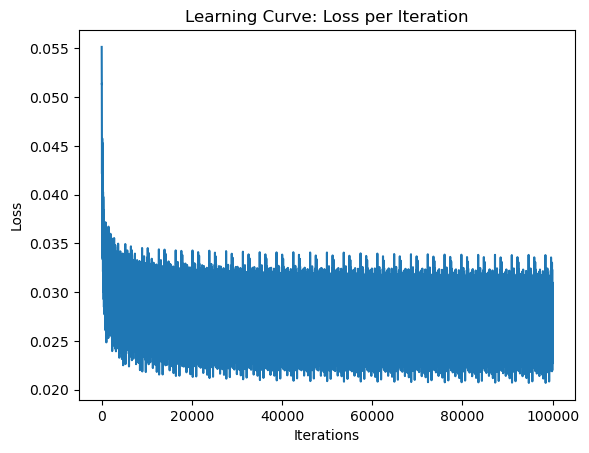

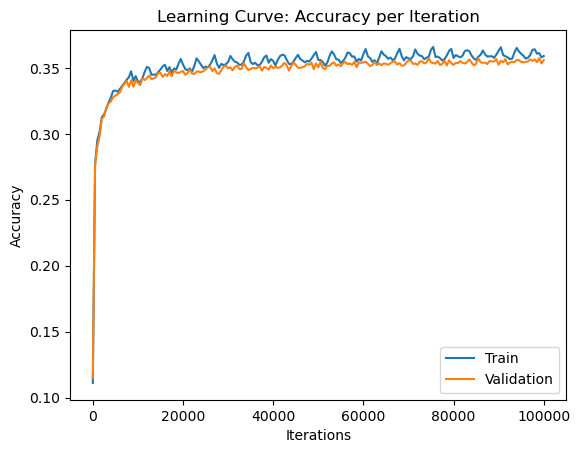

In [30]:
plot_learning_curve(*learning_curve_info)

### V. BUILDING A PREDICTIVE SYSTEM

Writing a function `make_prediction_torch` that takes as parameters
a PyTorchWordEmb model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

As well as a function `make_prediction_numpy` that takes as parameters
a NumpyWordEmbModel model and sentence (a list of words), and produces
a prediction for the next word in the sentence.


In [31]:
def make_prediction_torch(model, sentence):

    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). Assume
    that len(sentence) >= 3 and that `model` is an instance of
    PyTorchWordEmb.

    This function returns the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_model, ['you', 'are', 'a'])
    """

    global vocab_stoi, vocab_itos
    last3 = sentence[-3:]
    word1_onehot = make_onehot(vocab_stoi[last3[0].lower()])
    word2_onehot = make_onehot(vocab_stoi[last3[1].lower()])
    word3_onehot = make_onehot(vocab_stoi[last3[2].lower()])

    data_arr = np.array([word1_onehot, word2_onehot, word3_onehot]).reshape(1, 3, word1_onehot.shape[0]).astype(np.float32)
    y = model.forward(torch.tensor(data_arr))
    pred = int(y.argmax())

    return vocab_itos[pred]

def make_prediction_numpy(model, sentence):
    global vocab_stoi, vocab_itos
    last3 = sentence[-3:]
    word1_onehot = make_onehot(vocab_stoi[last3[0].lower()])
    word2_onehot = make_onehot(vocab_stoi[last3[1].lower()])
    word3_onehot = make_onehot(vocab_stoi[last3[2].lower()])

    data_arr = np.array([word1_onehot, word2_onehot, word3_onehot]).reshape(1, 3, word1_onehot.shape[0])
    y = model(data_arr)
    pred = int(y.argmax())

    return vocab_itos[pred]


In [32]:
make_prediction_torch(pytorch_model, ['you', 'are', 'a']) # 36% training accuracy 

'good'

In [33]:
make_prediction_torch(pytorch44_train, ['you', 'are', 'a']) # 44% training accuracy 

'good'

In [34]:
make_prediction_numpy(numpy_model, ['you', 'are', 'a'])

'good'

In [35]:
sentences = ["You are a", "few companies show", "There are no", "yesterday I was", "the game had", "yesterday the federal"]

In [47]:
print("Model: Pytorch 44")
for sentence in sentences:
    print("Sentence: {}     Prediction: {}".format(sentence, make_prediction_torch(pytorch44_train, sentence.split())))

print("\nModel: Numpy")
for sentence in sentences:
    print("Sentence: {}     Prediction: {}".format(sentence, make_prediction_numpy(numpy_model, sentence.split())))

Model: Pytorch 44
Sentence: You are a     Prediction: good
Sentence: few companies show     Prediction: .
Sentence: There are no     Prediction: children
Sentence: yesterday I was     Prediction: just
Sentence: the game had     Prediction: to
Sentence: yesterday the federal     Prediction: government

Model: Numpy
Sentence: You are a     Prediction: good
Sentence: few companies show     Prediction: .
Sentence: There are no     Prediction: .
Sentence: yesterday I was     Prediction: .
Sentence: the game had     Prediction: to
Sentence: yesterday the federal     Prediction: states


### TEST ACCURACY

In [54]:
###
print("Test accuracy for numpy model: {}%".format(round(estimate_accuracy(numpy_model, test4grams, test4grams.shape[0]) * 100, 2)))
print("\n")
print("Test accuracy for pytorch model (36% train acc): {}%".format(round(estimate_accuracy_torch(pytorch_model, test4grams, test4grams.shape[0]) * 100, 2)))
print("\n")
print("Test accuracy for pytorch model (44% train acc): {}%".format(round(estimate_accuracy_torch(pytorch44_train, test4grams, test4grams.shape[0]) * 100, 2)))

Test accuracy for numpy model: 34.11%


Test accuracy for pytorch model (36% train acc): 35.58%


Test accuracy for pytorch model (44% train acc): 38.86%


### VI. ANALYSING AND VISUALIZING WORD EMBEDDINGS

While training the `PyTorchWordEmb`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. We will now explore these word embeddings.

The basic idea behind word embeddings is to represent words as dense vectors in a high-dimensional space, such that semantically similar words are located close to each other in this space.

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.

In [55]:
word_emb_weights = list(pytorch_model.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T

In a word embedding layer, each row represents the vector representation of a particular word. This is because each word is assigned a unique index in the vocabulary, and the word embedding layer consists of a matrix where the ith row represents the vector representation of the word with index i in the vocabulary.

In [58]:
## Vector representation of the word any
word_emb[vocab_stoi["any"],:]

array([-0.22963902, -0.00668644, -0.00057415,  0.34025943,  0.05852031,
        0.01574237,  0.02098473,  0.00116343, -0.18594447, -0.00557983,
        0.00201409, -0.09206037,  0.1761023 , -0.06522124, -0.26269898,
        0.00999003,  0.01155758,  0.01622141,  0.01951406, -0.17247754,
       -0.09312766, -0.07567266,  0.00130722, -0.17469205,  0.14096022,
        0.02367751,  0.01496422,  0.0653801 , -0.1542324 ,  0.00669485,
        0.07107662,  0.03578935,  0.13057941, -0.3118191 ,  0.00992796,
        0.01407288,  0.14817467,  0.23735267,  0.09844705, -0.06836256,
       -0.13002233,  0.06842956,  0.08356576,  0.22398174, -0.01133957,
       -0.14161351, -0.03371129,  0.12437217,  0.06475918, -0.02216923,
        0.20390312, -0.00839575,  0.01034337, -0.05581548,  0.01922484,
        0.05784843, -0.0744231 ,  0.28390598, -0.0546674 ,  0.0029442 ,
        0.29639903,  0.07143375,  0.26989847, -0.08515854, -0.04424564,
        0.00071744, -0.26318586, -0.06890774,  0.06506017,  0.06

During the training process, the word embedding layer is learned from a large corpus of text, such that words that appear in similar contexts are assigned similar vector representations. This allows the word embeddings to capture both the syntactic and semantic relationships between words in the language.

To show this, we will compute the cosine similarity of
every pair of words in our vocabulary.

In [59]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.5163561
-0.1189338


Lets compute the 5 closest words to the followinf words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [66]:
def get_sims(w):
    sims = {}
    for w2 in vocab:
        if w != w2:
            sims[w2] = similarities[vocab_stoi[w], vocab_stoi[w2]]
    return sims

words = ["four", "go", "what", "should", "school", "your", "yesterday", "not"]
for w in words:
    sims = get_sims(w)
    closest5 = sorted(sims, key=sims.get, reverse=True)[:5]
    print("Closest words to '{}' are: ".format(w))
    for c in closest5:
        print("{} : {}".format(c, sims[c]))
    print("\n")


Closest words to 'four' are: 
three : 0.9761074185371399
five : 0.9623426795005798
two : 0.9422858953475952
several : 0.9054398536682129
few : 0.8759233355522156


Closest words to 'go' are: 
come : 0.5981422662734985
back : 0.5855469703674316
going : 0.5434026718139648
get : 0.42102065682411194
down : 0.4184490144252777


Closest words to 'what' are: 
who : 0.5157886743545532
which : 0.4897661805152893
when : 0.4587644934654236
how : 0.4489874541759491
- : 0.42256292700767517


Closest words to 'should' are: 
could : 0.8174335360527039
might : 0.8027524352073669
would : 0.8002309799194336
may : 0.6481191515922546
will : 0.6416106820106506


Closest words to 'school' are: 
music : 0.749408483505249
season : 0.6940215826034546
company : 0.6582933068275452
home : 0.6556110382080078
court : 0.6452583074569702


Closest words to 'your' are: 
their : 0.9506409168243408
his : 0.9271653294563293
our : 0.9271492958068848
my : 0.9049620032310486
its : 0.8879327774047852


Closest words to 'yest

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.

Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.

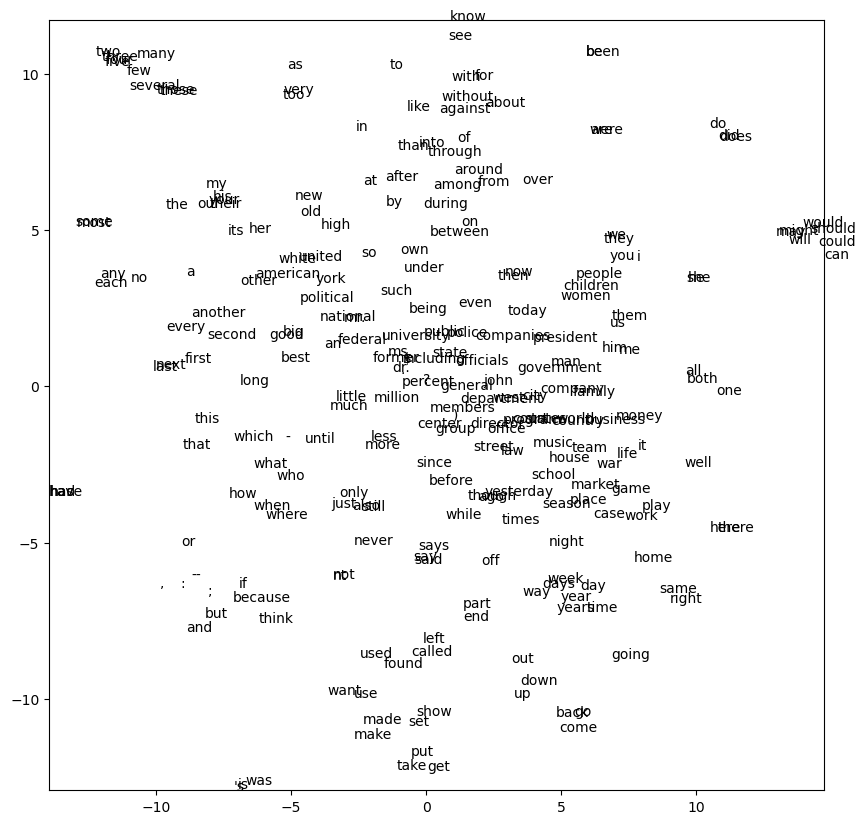

In [67]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

We can see a few cluster of words that syntactic and semantic similarity.